In [1]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import regex as re
import nltk
from keras import models
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

In [2]:
from tensorflow.keras.layers import Embedding,Flatten,Dense,LSTM
from tensorflow.keras.models import Sequential
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from keras.preprocessing.text import Tokenizer

In [3]:
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.datasets import make_classification
#from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
import seaborn as sns

In [4]:
from numpy.random import seed
seed(1)
tf.random.set_seed(1)

In [5]:
url='image_data/'
df_data_covid_19 = pd.read_csv('data/preprocessing.csv')
df_data_covid_19

,title,text,source,label
0,due recent outbreak coronavirus covid world he...,need add water drugs vaccines ready administer...,coronavirusmedicalkit com,fake
1,basic protective measures new coronavirus,stay aware latest information covid outbreak a...,ww int emergencies diseases novel coronavirus ...,true
2,exposing sun temperatures higher c degrees pre...,catch covid matter sunny hot weather countries...,ww int emergencies diseases novel coronavirus ...,true
3,able hold breath seconds without coughing feel...,common symptoms covid dry cough tiredness feve...,ww int emergencies diseases novel coronavirus ...,true
4,drinking alcohol protect covid dangerous,frequent excessive alcohol consumption increas...,ww int emergencies diseases novel coronavirus ...,true
...,...,...,...,...
1054,could power sun slow coronavirus,study suggests ultraviolet rays could slow vir...,ww nytimes com,true
1055,key evidence coronavirus spread flawed public ...,last week medical journal reported business tr...,ww nytimes com,true
1056,summer heat may diminish coronavirus strength,new report sent white house science adviser sa...,ww nytimes com,true
1057,long vaccine really take,vaccine would ultimate weapon coronavirus best...,ww nytimes com,true


In [6]:
def merge_3_columns(df):
    df['title_text_source'] = df['title'] + ' ' + df['text'] + ' ' + df['source']
    return df.dropna()

df_data_covid_19=merge_3_columns(df_data_covid_19)

In [7]:
df_data_covid_19['label']=df_data_covid_19['label'].replace('true',1).replace('fake',0)

<ipython-input-7-cc09997627b7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data_covid_19['label']=df_data_covid_19['label'].replace('true',1).replace('fake',0)


# Division of the dataframe

In [8]:
int(len(df_data_covid_19)*0.2)

211

In [9]:
data_test =df_data_covid_19.iloc[:211]
data_modle =df_data_covid_19.iloc[211:]

## RNN

In [10]:
vocab_size=5000
y=data_modle['label']

In [32]:
def one_hot_and_embedded(data_,vocab_size):
    messages=data_.copy()
    messages.reset_index(inplace=True)
    messages=messages['title_text_source']
    one_hot_rep=[one_hot(words,vocab_size) for words in messages]
    embedded_docs=pad_sequences(one_hot_rep,padding='pre',maxlen=60)
    return embedded_docs

In [33]:
embedded_docs=one_hot_and_embedded(data_modle,vocab_size)
embedded_docs[0]

[2665, 3853]


array([ 929, 2186, 1632, 2306,  277,    7, 1884,  682, 4678, 2942,  189,
       4437, 4274, 4961, 4397, 4187, 2165, 2188, 1165, 3881, 4523,  983,
       4523, 1219, 1021, 4380, 1365, 2749, 2430, 1176,  294, 3807, 3050,
        687, 4033, 3807,  219, 1726, 2257, 4187, 3285, 3512, 3264, 3907,
        819, 1325,  791, 1210, 3530, 1365, 1163, 1459, 4380, 1380, 2506,
       4238, 1380, 2277, 4363, 1380])

In [13]:
def get_model(vocab_size):
    embedded_features=40
    model=Sequential()
    model.add(Embedding(vocab_size,embedded_features,input_length=60))
    model.add(LSTM(100))
    model.add(Dense(1,activation='sigmoid'))
    model.summary()
    model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
    return model

In [14]:
model=get_model(vocab_size)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 60, 40)            200000    
_________________________________________________________________
lstm (LSTM)                  (None, 100)               56400     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 256,501
Trainable params: 256,501
Non-trainable params: 0
_________________________________________________________________


In [15]:
def fit_and_split(embedded_docs,y,model,vocab_size):
    X_final=np.asarray(embedded_docs)
    y_final=np.asarray(y)
    X_train,X_test,y_train,y_test=train_test_split(X_final,y_final)
    history=model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=50)
    # save model
    model.save("data/rnn_model")
    np.save('data/rnn_history.npy',history.history)
    return X_test, y_test

In [16]:
X_test, y_test=fit_and_split(embedded_docs,y,model,vocab_size)

Epoch 1/50
20/20 [==============================] - 5s 127ms/step - loss: 0.6835 - accuracy: 0.5262 - val_loss: 0.6216 - val_accuracy: 0.5849
Epoch 2/50
20/20 [==============================] - 1s 33ms/step - loss: 0.4767 - accuracy: 0.7097 - val_loss: 0.3860 - val_accuracy: 0.9009
Epoch 3/50
20/20 [==============================] - 1s 30ms/step - loss: 0.3869 - accuracy: 0.9515 - val_loss: 0.4463 - val_accuracy: 0.8915
Epoch 4/50
20/20 [==============================] - 1s 29ms/step - loss: 0.2992 - accuracy: 0.9525 - val_loss: 0.2631 - val_accuracy: 0.8868
Epoch 5/50
20/20 [==============================] - 1s 29ms/step - loss: 0.0687 - accuracy: 0.9834 - val_loss: 0.2504 - val_accuracy: 0.8962
Epoch 6/50
20/20 [==============================] - 1s 31ms/step - loss: 0.0209 - accuracy: 0.9969 - val_loss: 0.2277 - val_accuracy: 0.9057
Epoch 7/50
20/20 [==============================] - 1s 41ms/step - loss: 0.0209 - accuracy: 1.0000 - val_loss: 0.2259 - val_accuracy: 0.9104
Epoch 8/50
2

INFO:tensorflow:Assets written to: data/rnn_model\assets


INFO:tensorflow:Assets written to: data/rnn_model\assets


In [17]:
# load model
load_history=np.load('data/rnn_history.npy',allow_pickle='TRUE').item()
train_model = models.load_model("data/rnn_model")
train_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 60, 40)            200000    
_________________________________________________________________
lstm (LSTM)                  (None, 100)               56400     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 256,501
Trainable params: 256,501
Non-trainable params: 0
_________________________________________________________________


In [18]:
def loss_model(name_loss):
    plt.plot(load_history[name_loss],'b',label='train_'+name_loss)
    plt.plot(load_history['val_'+name_loss],'r',label='val_'+name_loss)
    plt.savefig(url+name_loss+'.png')
    plt.legend()
    plt.show()
    plt.close()

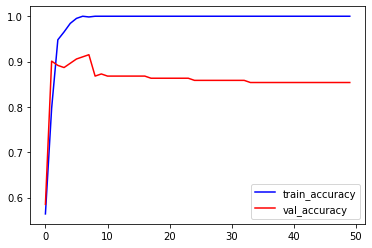

In [19]:
loss_model('accuracy')

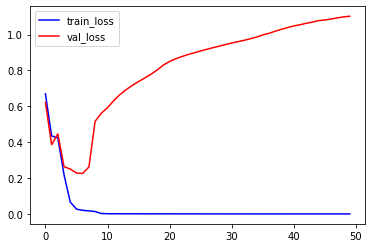

In [20]:
loss_model('loss')

In [21]:
print(train_model.evaluate(X_test, y_test))

7/7 [==============================] - 1s 12ms/step - loss: 1.1018 - accuracy: 0.8538
[1.101843237876892, 0.8537735939025879]


Accuracy Classifier: 85.38%
              precision    recall  f1-score   support

           0       0.76      0.87      0.81        77
           1       0.92      0.84      0.88       135

    accuracy                           0.85       212
   macro avg       0.84      0.86      0.85       212
weighted avg       0.86      0.85      0.86       212



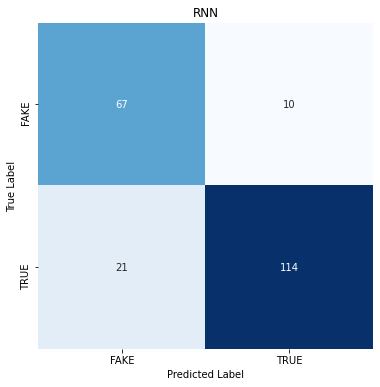

In [22]:
pred = train_model.predict(X_test)
binary_predictions = []

for i in pred:
    if i >= 0.5:
        binary_predictions.append(1)
    else:
        binary_predictions.append(0) 
        
print("Accuracy Classifier: {}%".format(round(accuracy_score(binary_predictions, y_test)*100,2)))
print(classification_report(binary_predictions, y_test))

# confusion matrix
cm = confusion_matrix(binary_predictions, y_test)

plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=['FAKE', 'TRUE'], yticklabels=['FAKE', 'TRUE'], cmap=plt.cm.Blues, cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('RNN')
plt.savefig(url+'RNN.png')
plt.show()

In [23]:
def get_predict(data_test,vocab_size):
    test_data_new= one_hot_and_embedded(data_test,vocab_size)
    test_data_new = np.array(test_data_new)
    pred=train_model.predict(test_data_new)
    data_test['predict']=np.round(pred).astype('int')
    return data_test

In [24]:
data_test= get_predict(data_test,vocab_size)

<ipython-input-23-aa3466540a91>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test['predict']=np.round(pred).astype('int')


In [25]:
data_test

,title,text,source,label,title_text_source,predict
0,due recent outbreak coronavirus covid world he...,need add water drugs vaccines ready administer...,coronavirusmedicalkit com,0,due recent outbreak coronavirus covid world he...,1
1,basic protective measures new coronavirus,stay aware latest information covid outbreak a...,ww int emergencies diseases novel coronavirus ...,1,basic protective measures new coronavirus stay...,1
2,exposing sun temperatures higher c degrees pre...,catch covid matter sunny hot weather countries...,ww int emergencies diseases novel coronavirus ...,1,exposing sun temperatures higher c degrees pre...,1
3,able hold breath seconds without coughing feel...,common symptoms covid dry cough tiredness feve...,ww int emergencies diseases novel coronavirus ...,1,able hold breath seconds without coughing feel...,1
4,drinking alcohol protect covid dangerous,frequent excessive alcohol consumption increas...,ww int emergencies diseases novel coronavirus ...,1,drinking alcohol protect covid dangerous frequ...,1
...,...,...,...,...,...,...
206,vaccine job eugenicist bill gates demands digi...,march outspoken eugenicist bill gates particip...,ww banned news,0,vaccine job eugenicist bill gates demands digi...,0
207,vaccine job eugenicist bill gates demands digi...,march outspoken eugenicist bill gates particip...,ww biased news,0,vaccine job eugenicist bill gates demands digi...,0
208,coronavirus manufactured bioweapon chinese spi...,mysterious shipment sent canada china found co...,ww biased news,0,coronavirus manufactured bioweapon chinese spi...,0
209,special report mike adams joins alex jones rev...,today joined alex jones infowars studios recor...,ww biased news,0,special report mike adams joins alex jones rev...,0
